# Plots

This is a workspace for much of the plotting/data vis I need to do. I will do my best not to repeat visualisations created in the other files here

## Library Imports

In [59]:
#Basics
import pandas as pd
import geopandas as gpd
import numpy as np

#Plots and Stats
import matplotlib.pyplot as plt
import seaborn as sns

# Geometry
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon

## Data Imports

In [51]:
# Raw Overture Maps Places
london_places = gpd.read_file('data/overture_data/london_places.geojson')
bham_places = gpd.read_file('data/overture_data/bham_places.geojson')

# All London Data
all_data_london = pd.read_csv("data/combined_data/lag/all_data_london_lag.csv")

# All Birmingham Data
all_data_bham = pd.read_csv("data/combined_data/lag/all_data_bham_lag.csv")

# Convert data to GDF
all_data_london['geometry'] = all_data_london['geometry'].apply(wkt.loads)
all_data_bham['geometry'] = all_data_bham['geometry'].apply(wkt.loads)

all_data_london = gpd.GeoDataFrame(all_data_london, geometry='geometry')
all_data_bham = gpd.GeoDataFrame(all_data_bham, geometry='geometry')

all_data_london.set_crs(epsg=4326, inplace=True)
all_data_bham.set_crs(epsg=4326, inplace=True)

# Filter places to boundary areas
london_places_join = gpd.sjoin(london_places, all_data_london, how='inner', op='within')
bham_places_join = gpd.sjoin(bham_places, all_data_bham, how='inner', op='within')

london_places = london_places_join[london_places.columns]
bham_places = bham_places_join[bham_places.columns]

/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [52]:
# Sanity Check
london_places.head()

,name,category,confidence,geometry
1519,"The Star, Malden Rushett",pub,0.96,POINT (-0.32762 51.32683)
1520,Hillcroft Bed And Breakfast,bed_and_breakfast,0.77,POINT (-0.32662 51.32736)
1521,C-Ceramics,None,0.77,POINT (-0.32662 51.32736)
36917,The Star Gun Club,active_life,0.86,POINT (-0.32914 51.32922)
36918,Byhurst Farm Clay Shoot,farm,0.92,POINT (-0.32463 51.33735)


## Plots

### Kernel Density Estimation - Overture Maps Places

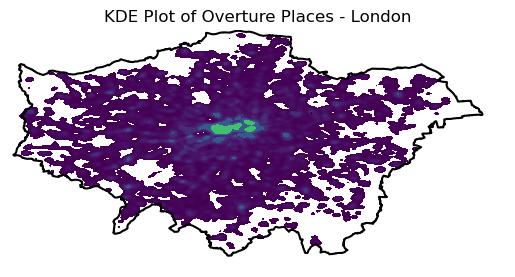

In [73]:
# Plot for Greater London

sns.kdeplot(
    x=london_places.geometry.x,
    y=london_places.geometry.y,
    cmap='viridis',
    fill=True,
    bw_adjust=0.2
)

greater_london_boundary = all_data_london.unary_union
boundary_gdf = gpd.GeoDataFrame(geometry=[greater_london_boundary], crs=all_data_london_gdf.crs)
boundary_gdf.boundary.plot(ax=plt.gca(), color='black')

# Add labels and title
plt.axis('off')
plt.title('KDE Plot of Overture Places - London')

# Show the plot
plt.show()

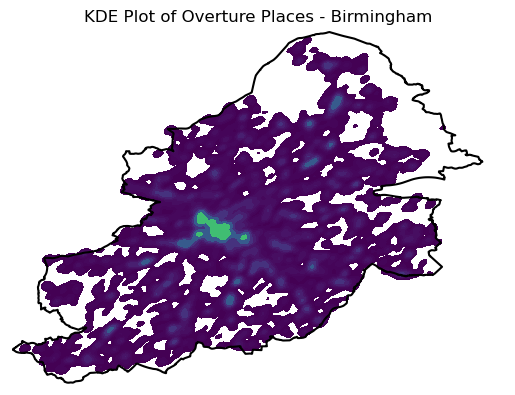

In [74]:
# Plot for Birmingham

sns.kdeplot(
    x=bham_places.geometry.x,
    y=bham_places.geometry.y,
    cmap='viridis',
    fill=True,
    bw_adjust=0.2
)

bham_boundary = all_data_bham.unary_union
boundary_gdf = gpd.GeoDataFrame(geometry=[bham_boundary], crs=all_data_bham_gdf.crs)
boundary_gdf.boundary.plot(ax=plt.gca(), color='black')

# Add labels and title
plt.axis('off')
plt.title('KDE Plot of Overture Places - Birmingham')

# Show the plot
plt.show()

### Frequency of Place Types (Top 20)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_20932/858719427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_top.values, y=category_top.index, palette='viridis')


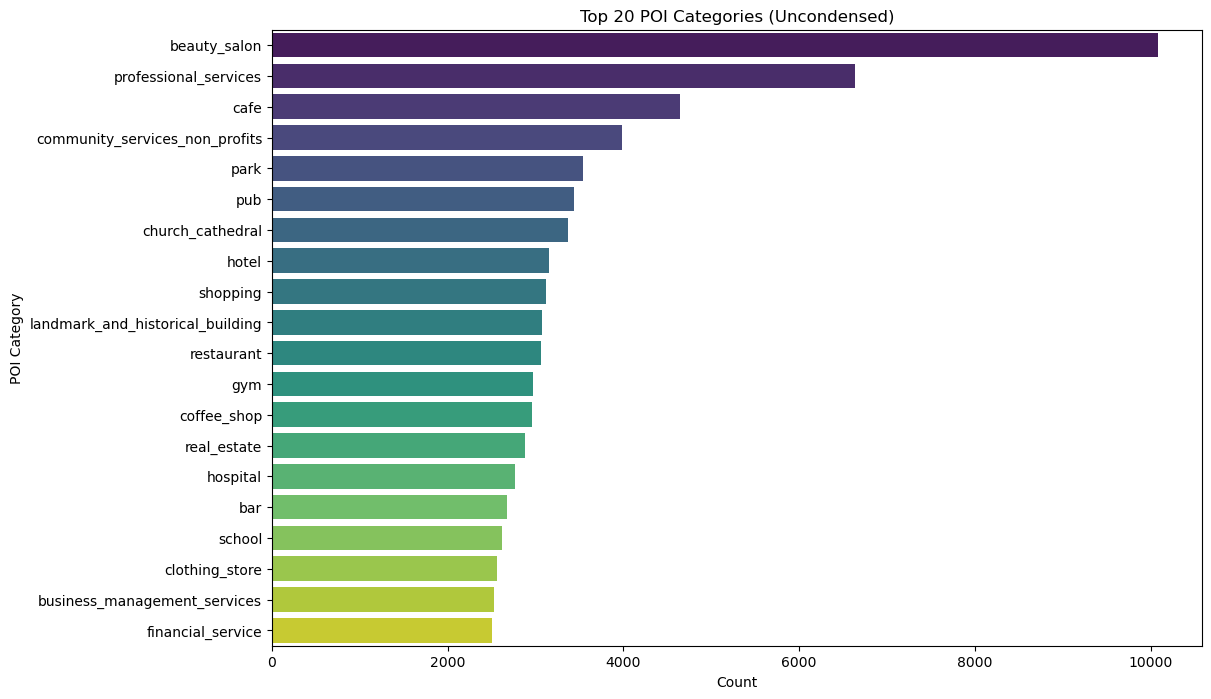

In [201]:
all_places = pd.concat([london_places, bham_places], axis=0)

category_counts = all_places['category'].value_counts()

category_top = all_places['category'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=category_top.values, y=category_top.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('POI Category')
plt.title('Top 20 POI Categories (Uncondensed)')
plt.show()

### Frequency of Place Types (Top 20 Condensed)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_20932/2920979480.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condensed_top['Count'], y=condensed_top.index, palette='viridis')


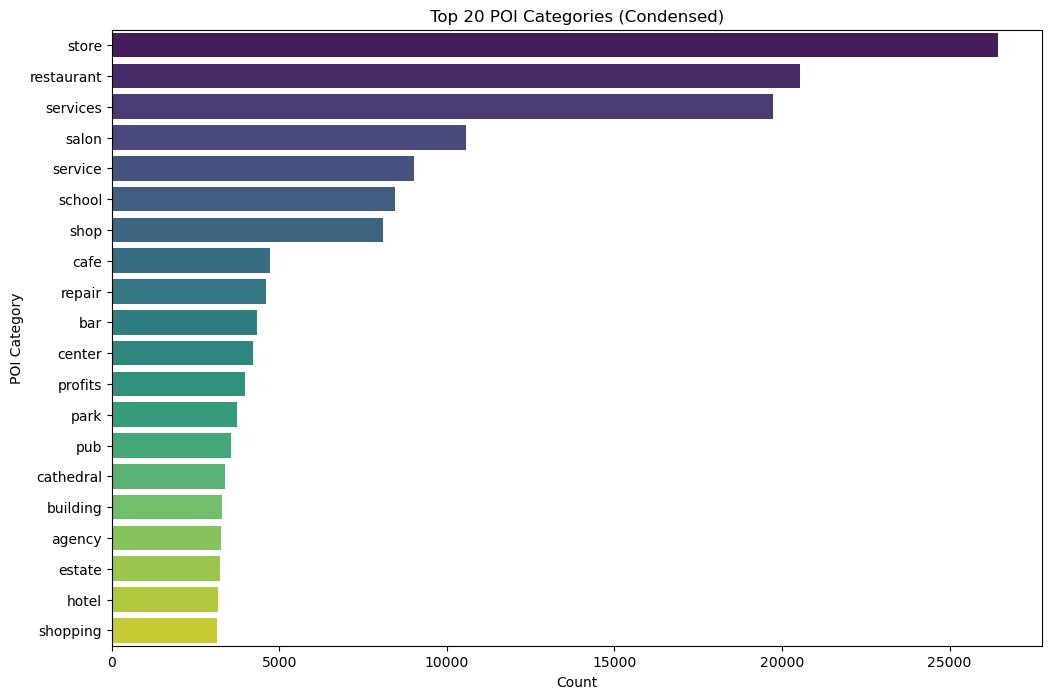

In [211]:
# Recycle the category collapse logic from DataCleaning.ipynb

# Automated Condensing of Column Types

# I'll group them by 'suffix' to find commonalities
suffix_groups = {}

# Iterate through
for index in category_counts.index:
    lower_index = index.lower()
    parts = lower_index.split('_')
    if len(parts) > 1:
        suffix = parts[-1]
        if suffix in suffix_groups:
            suffix_groups[suffix] += category_counts.loc[index].sum()
        else:
            suffix_groups[suffix] = category_counts.loc[index].sum()
    else:
        # Handle rows without suffixes
        suffix_groups[parts[0]] = category_counts.loc[index].sum()

condensed_categories = pd.DataFrame.from_dict(suffix_groups, orient='index', columns=['Count'])

condensed_categories_sorted = condensed_categories.sort_values(by='Count', ascending=False)

condensed_top = condensed_categories_sorted.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=condensed_top['Count'], y=condensed_top.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('POI Category')
plt.title('Top 20 POI Categories (Condensed)')
plt.show()

### Collinearity Checks

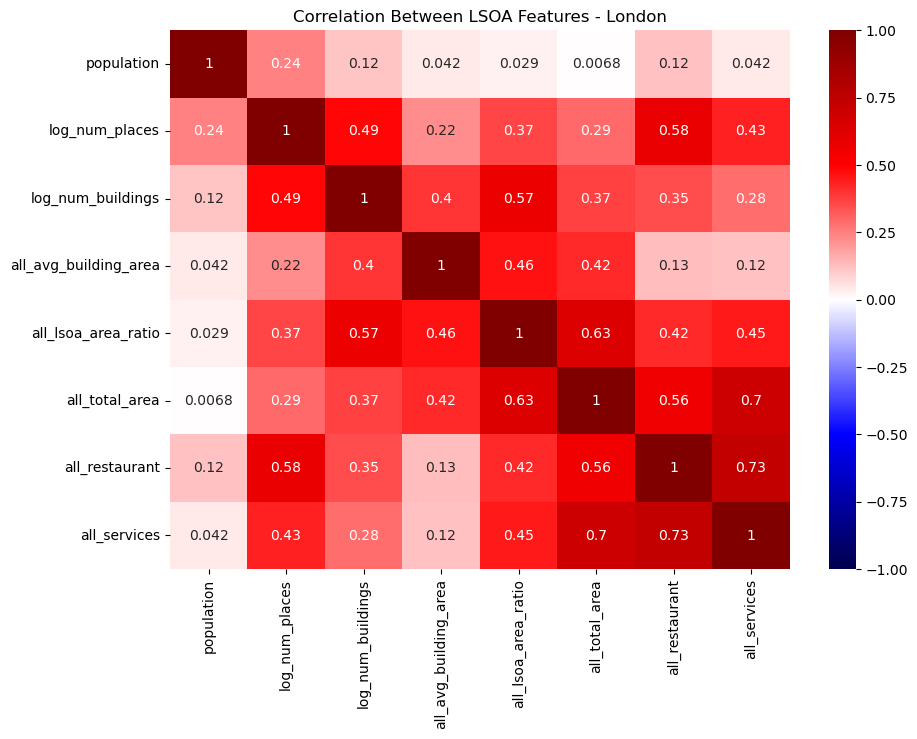

In [115]:
# London

selected_columns = [
    'population',
    'log_num_places',
    'log_num_buildings',
    'all_avg_building_area',
    'all_lsoa_area_ratio',
    'all_total_area',
    'all_restaurant',
    'all_services',
]

colinearity_features = all_data_london[selected_columns]

plt.figure(figsize=(10,7))

# Heatmap
sns.heatmap(colinearity_features.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Between LSOA Features - London')
plt.show()


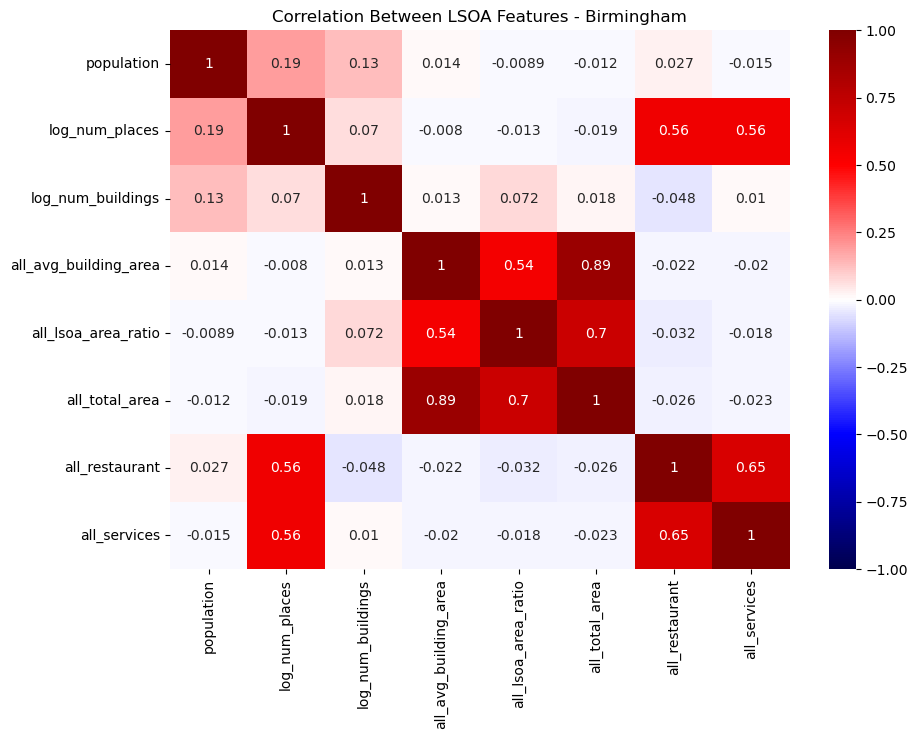

In [117]:
# Birmingham

selected_columns = [
    'population',
    'log_num_places',
    'log_num_buildings',
    'all_avg_building_area',
    'all_lsoa_area_ratio',
    'all_total_area',
    'all_restaurant',
    'all_services',
]

colinearity_features = all_data_bham[selected_columns]

plt.figure(figsize=(10,7))

# Heatmap
sns.heatmap(colinearity_features.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Between LSOA Features - Birmingham')
plt.show()


### Example Building Footprint Images

### (logged) Feature Distribution Maps

### Overture Confidence Histogram